In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.0/540.0 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 r

In [2]:
# Standard libraries
import os
import warnings
import math
import random
from pathlib import Path
from collections import Counter, OrderedDict
from typing import List, Tuple, Dict, Optional, Union, Callable
from enum import IntEnum

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm import tqdm
from ipywidgets import interact

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# Torchvision
import torchvision.transforms as transforms

# Flower
import flwr
from flwr.client import Client, ClientApp
from flwr.client import NumPyClient, Client
from flwr.common import (
    Status, Parameters, Scalar, NDArray, NDArrays, ndarrays_to_parameters, parameters_to_ndarrays, Context
)
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import Strategy
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

# HuggingFace Datasets
from datasets.utils.logging import disable_progress_bar, set_verbosity_error

2025-05-08 19:54:31.817725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746734072.278650      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746734072.413402      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Thiết lập thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()
set_verbosity_error()
warnings.filterwarnings("ignore")

Training on cuda
Flower 1.18.0 / PyTorch 2.5.1+cu124


In [4]:
# Hằng số
NUM_CLIENTS = 5
NUM_ROUNDS = 25

# Định nghĩa drop out
class CustomCode(IntEnum):
    DROPPED_OUT = 100

In [5]:
data_dir = '/kaggle/input/mri-dataset/datasetzip/not_skull_stripped'
label_path = list(Path(data_dir).glob("*.xlsx"))
label_ls = pd.read_excel(label_path[0])
label_ls

,subject_age,subject_dx,subject_sex,subject_id,dataset_name
0,55.4,pathology,m,sub-BrainAge000000,ABIDE/Caltech
1,22.9,pathology,m,sub-BrainAge000001,ABIDE/Caltech
2,39.2,pathology,m,sub-BrainAge000002,ABIDE/Caltech
3,22.8,pathology,m,sub-BrainAge000003,ABIDE/Caltech
4,34.6,pathology,f,sub-BrainAge000004,ABIDE/Caltech
...,...,...,...,...,...
23209,66,control,f,sub-BrainAge023209,RocklandSample
23210,69,control,m,sub-BrainAge023210,RocklandSample
23211,23,control,m,sub-BrainAge023211,RocklandSample
23212,54,control,f,sub-BrainAge023212,RocklandSample


In [6]:
label_ls = label_ls[(label_ls['subject_dx'] == 'control') & ((label_ls['subject_sex'] == 'm') | (label_ls['subject_sex'] == 'f'))]
len(label_ls)

8764

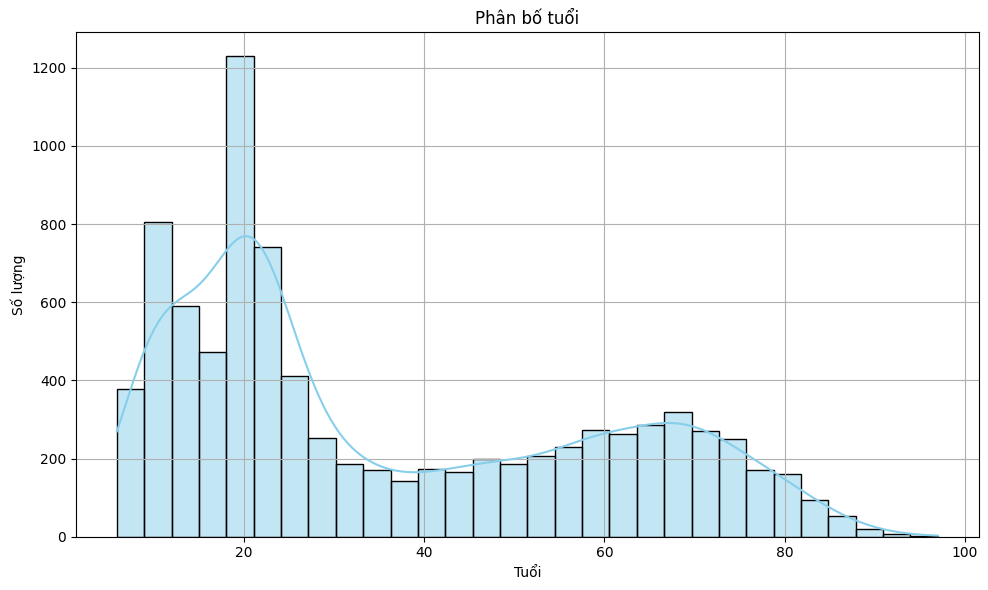

In [7]:
label_ls['subject_age'] = pd.to_numeric(label_ls['subject_age'], errors='coerce')

# Loại bỏ các dòng có giá trị NaN sau khi chuyển đổi
label_ls = label_ls.dropna(subset=['subject_age'])

# Vẽ biểu đồ phân bố tuổi
plt.figure(figsize=(10, 6))
sns.histplot(label_ls['subject_age'], bins=30, kde=True, color='skyblue')
plt.title('Phân bố tuổi')
plt.xlabel('Tuổi')
plt.ylabel('Số lượng')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
subject_metadata = label_ls[['subject_sex','subject_id','dataset_name','subject_age']]
subject_metadata

,subject_sex,subject_id,dataset_name,subject_age
19,m,sub-BrainAge000019,ABIDE/Caltech,44.2
20,m,sub-BrainAge000020,ABIDE/Caltech,39.3
21,m,sub-BrainAge000021,ABIDE/Caltech,42.5
22,m,sub-BrainAge000022,ABIDE/Caltech,19.7
23,f,sub-BrainAge000023,ABIDE/Caltech,20.0
...,...,...,...,...
23209,f,sub-BrainAge023209,RocklandSample,66.0
23210,m,sub-BrainAge023210,RocklandSample,69.0
23211,m,sub-BrainAge023211,RocklandSample,23.0
23212,f,sub-BrainAge023212,RocklandSample,54.0


In [9]:
subject_metadata_dict = label_ls.set_index('subject_id')[['subject_sex','dataset_name','subject_age']].to_dict(orient='index')
len(subject_metadata_dict)

8717

In [10]:
class MRIDataset(Dataset):
    def __init__(self, im_dir, label_ls, transform=None, im_filenames=None):
        self.im_dir = Path(im_dir)
        self.label_ls = label_ls
        self.transform = transform

        if im_filenames is not None:
            self.im_filenames = im_filenames
        else:
            self.im_filenames = self._gather_valid_paths()

    def _gather_valid_paths(self):
        paths = self.im_dir.glob("*/*/*/*.nii")
        valid_paths = []
        fail_paths = {
            self.im_dir / "sub-BrainAge005600/anat/sub-BrainAge005600_T1w.nii/sub-BrainAge005600_T1w.nii"
        }

        for path in paths:
            if not path.is_file():
                continue
                
            if path in fail_paths:
                continue
                
            subject_id = self._extract_subject_id(path)
            if subject_id not in self.label_ls:
                continue
            try:
                # nib.load(path).get_fdata()
                nib.load(path)
                valid_paths.append(path)
            except Exception:
                continue
        return valid_paths

    def _extract_subject_id(self, path):
        for part in Path(path).parts:
            if part.startswith("sub-BrainAge"):
                return part  # ví dụ: "sub-BrainAge000000"
        return None

    def _normalize(self, im):
        im = (im - np.min(im)) / (np.max(im) - np.min(im) + 1e-5)
        return im.astype(np.float32)

    def _get_label(self, subject_id):
        sex = self.label_ls.get(subject_id, {}).get("subject_sex")
        if sex == 'm':
            return 0
        elif sex == 'f':
            return 1
        else:
            raise ValueError(f"Invalid label for subject {subject_id}: {sex}")
            
    def _get_age(self, subject_id):
        return self.label_ls.get(subject_id, {}).get("subject_age")
    
    def __len__(self):
        return len(self.im_filenames)

    def __getitem__(self, idx):
        im_path = self.im_filenames[idx]
        subject_id = self._extract_subject_id(im_path)

        im = nib.load(im_path).get_fdata()
        im = self._normalize(im)

        label = self._get_label(subject_id)
        image = torch.from_numpy(im).unsqueeze(0)  # Shape: (1, H, W, D)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)
        
    def num_classes(self):
        class_set = set()
        for idx in range(len(self)):
            _, label = self[idx]
            class_set.add(label.item())
        return len(class_set) 

In [11]:
from collections import defaultdict

def get_dirichlet_partition_indices(data: MRIDataset, num_clients: int, alpha: float, num_bins: int = 8):
    subject_ids = [data._extract_subject_id(path) for path in data.im_filenames]
    subject_metadata = data.label_ls

    age_array = np.array([
        subject_metadata.get(sid, {}).get("subject_age", np.nan)
        for sid in subject_ids
    ], dtype=np.float32)

    valid_mask = ~np.isnan(age_array)
    valid_indices = np.arange(len(data.im_filenames))[valid_mask]
    age_array = age_array[valid_mask]

    # Create age bins
    bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
    age_bins = np.digitize(age_array, bins, right=False)  # values from 1 to num_bins

    # Group indices by bin
    bin_to_indices = defaultdict(list)
    for idx, bin_id in zip(valid_indices, age_bins):
        bin_to_indices[bin_id].append(idx)

    client_indices = [[] for _ in range(num_clients)]

    # Distribute each bin to clients using Dirichlet
    for bin_id, indices in bin_to_indices.items():
        if len(indices) < num_clients:
            continue  # skip bins with too few samples
        proportions = np.random.dirichlet([alpha] * num_clients)
        proportions = (np.cumsum(proportions) * len(indices)).astype(int)[:-1]
        split_indices = np.split(np.random.permutation(indices), proportions)
        for cid, idx in enumerate(split_indices):
            client_indices[cid].extend(idx)

    return client_indices


In [12]:
def load_client_datasets(partition_id: int, num_partitions: int, dataset, alpha: float, num_samples: int = None):
    all_client_indices = get_dirichlet_partition_indices(dataset, num_partitions, alpha)
    client_data_indices = all_client_indices[partition_id]

    if num_samples is not None:
        client_data_indices = np.random.choice(client_data_indices, size=min(num_samples, len(client_data_indices)), replace=False)

    np.random.shuffle(client_data_indices)
    train_size = int(0.8 * len(client_data_indices))
    train_indices = client_data_indices[:train_size]
    val_indices = client_data_indices[train_size:]

    return Subset(dataset, train_indices), Subset(dataset, val_indices)


In [13]:
def load_server_test_datasets(data: MRIDataset):
    testloader = DataLoader(data, batch_size=8, shuffle=False)
    return testloader

In [14]:
import json

def load_filenames(input_path):
    input_path = Path(input_path)
    if not input_path.is_file():
        raise FileNotFoundError(f"File {input_path} không tồn tại")
    with open(input_path, 'r') as f:
        return [Path(path) for path in json.load(f)]

In [15]:
im_filenames = load_filenames("/kaggle/input/mri-dataset/mri_dataset.json")

In [16]:
dataset = MRIDataset(data_dir, subject_metadata_dict, im_filenames = im_filenames)
len(dataset)

4948

In [17]:
def save_filenames(im_filenames, output_path):
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump([str(path) for path in im_filenames], f)
    print(f"Đã lưu im_filenames vào: {output_path}")

In [18]:
save_filenames(dataset.im_filenames, "mri_dataset.json")

Đã lưu im_filenames vào: mri_dataset.json


In [19]:
from sklearn.model_selection import train_test_split

all_filenames = dataset.im_filenames

# Chia train/test 
train_filenames, test_filenames = train_test_split(
    all_filenames, test_size=0.2, random_state=42, shuffle=True
)

trainset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=train_filenames
)

testset = MRIDataset(
    im_dir=dataset.im_dir,
    label_ls=dataset.label_ls,
    transform=dataset.transform,
    im_filenames=test_filenames
)

In [20]:
class _DenseLayer(nn.Sequential):

    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super().__init__()
        self.add_module('norm1', nn.BatchNorm3d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module(
            'conv1',
            nn.Conv3d(num_input_features,
                      bn_size * growth_rate,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module(
            'conv2',
            nn.Conv3d(bn_size * growth_rate,
                      growth_rate,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super().forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features,
                                     p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate,
                 drop_rate):
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate,
                                growth_rate, bn_size, drop_rate)
            self.add_module('denselayer{}'.format(i + 1), layer)


class _Transition(nn.Sequential):

    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.add_module('norm', nn.BatchNorm3d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module(
            'conv',
            nn.Conv3d(num_input_features,
                      num_output_features,
                      kernel_size=1,
                      stride=1,
                      bias=False))
        self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    
    """
    Densenet-BC model class
    
    Args:
        growth_rate (int) - how many filters to add each layer (k in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """

    def __init__(self,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 growth_rate=32,
                 block_config=(6, 12, 24, 16),
                 num_init_features=64,
                 bn_size=4,
                 drop_rate=0,
                 num_classes=1):

        super().__init__()

        # First convolution
        self.features = [('conv1',
                          nn.Conv3d(n_input_channels,
                                    num_init_features,
                                    kernel_size=(conv1_t_size, 7, 7),
                                    stride=(conv1_t_stride, 2, 2),
                                    padding=(conv1_t_size // 2, 3, 3),
                                    bias=False)),
                         ('norm1', nn.BatchNorm3d(num_init_features)),
                         ('relu1', nn.ReLU(inplace=True))]
        if not no_max_pool:
            self.features.append(
                ('pool1', nn.MaxPool3d(kernel_size=3, stride=2, padding=1)))
        self.features = nn.Sequential(OrderedDict(self.features))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers,
                                num_input_features=num_features,
                                bn_size=bn_size,
                                growth_rate=growth_rate,
                                drop_rate=drop_rate)
            self.features.add_module('denseblock{}'.format(i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition{}'.format(i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm3d(num_features))

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d) or isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool3d(out,
                                    output_size=(1, 1,
                                                 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

In [21]:
def get_parameters(net) -> List[np.ndarray]:
    # ONE numpy array per trainable tensor, in the exact order of net.parameters()
    return [p.detach().cpu().numpy() for p in net.parameters()]

def set_parameters(net, parameters: List[np.ndarray]):
    # Copy each incoming array back into the corresponding tensor
    for p, new_val in zip(net.parameters(), parameters):
        p.data.copy_(torch.from_numpy(new_val).to(p.device))

In [22]:
def compute_mean_grad(
    net: torch.nn.Module,
    trainloader: DataLoader,
    lr: float,
    K: int,
    device: str = "cuda:0",
) -> List[np.ndarray]:
    net.to(device).train()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss().to(device)

    sum_grads = [torch.zeros_like(p, device=device) for p in net.parameters()]
    total_steps = 0

    for epoch in range(K):
        epoch_loss = 0.0
        epoch_acc = 0.0
        epoch_steps = 0

        for batch_idx, (x, y) in enumerate(trainloader, 1):
            x = x.to(device)
            y = y.to(device).float().unsqueeze(1)  # [B,1]

            optimizer.zero_grad()
            logits = net(x)            # [B,1]
            loss = criterion(logits, y)
            loss.backward()

            # accumulate grads
            for idx, p in enumerate(net.parameters()):
                if p.grad is not None:
                    sum_grads[idx] += p.grad.detach()

            # compute batch accuracy
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            batch_acc = (preds == y).float().mean().item()

            optimizer.step()

            # track for printing
            epoch_loss += loss.item()
            epoch_acc  += batch_acc
            epoch_steps += 1
            total_steps += 1

        # at end of each local “epoch”:
        avg_loss = epoch_loss / epoch_steps
        avg_acc  = epoch_acc  / epoch_steps
        print(f"[Local epoch {epoch+1}/{K}]  loss = {avg_loss:.4f},  acc = {avg_acc:.4f}")

    # return the true mean gradient
    return [(g / total_steps).cpu().numpy() for g in sum_grads]




def evaluate_model(
    net: torch.nn.Module,
    loader: DataLoader,
    device: str = "cuda:0",
) -> Tuple[float, float]:
    net.to(device).eval()
    criterion = nn.BCEWithLogitsLoss().to(device)
    total_loss, acc_total = 0.0, 0.0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).float().unsqueeze(1)  # shape [B, 1]
            output = net(x)  # [B, 1] logit
            loss = criterion(output, y)
            total_loss += loss.item()

            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()
            acc_total += (preds == y).float().mean()

    avg_loss = total_loss / len(loader)
    avg_acc = acc_total / len(loader)
    print(f"Eval done: avg_loss = {avg_loss:.4f}, accuracy = {avg_acc:.4f}")
    return avg_loss, avg_acc


In [23]:
def is_dropout(partition_id: int, num_partitions: int) -> bool:
    prob = 0.2
    return random.random() < prob

# Định nghĩa Client
class FlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader, num_partitions, lr = 0.01, K=1):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.num_partitions = num_partitions
        self.lr = lr
        self.K = K

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        if is_dropout(self.partition_id, self.num_partitions):
            raise TimeoutError("Simulated client dropout")

        set_parameters(self.net, parameters)
        mean_gradients = compute_mean_grad(self.net, self.trainloader, self.lr, self.K)     
        print(f"[Client {self.partition_id}] FIT DONE", flush=True)
        return mean_gradients, len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        if is_dropout(self.partition_id, self.num_partitions):
            raise TimeoutError("Simulated client dropout")

        set_parameters(self.net, parameters)
        loss, accuracy = evaluate_model(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

# Hàm tạo client
def client_fn(context: Context) -> Client:
    partition_id = int(context.node_config["partition-id"])
    num_partitions = context.node_config["num-partitions"]
    
    train_subset, val_subset = load_client_datasets(partition_id, num_partitions, dataset=trainset, alpha = 0.2, num_samples = 4000)
    trainloader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
    valloader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

    net = model.to(DEVICE)
    return FlowerClient(partition_id, net, trainloader, valloader, num_partitions).to_client()


In [24]:
class MimiC(FedAvg):
    def __init__(
        self,
        *,
        server_learning_rate: float = 1,
        client_learning_rate: float = 0.01,
        fraction_fit: float = 1.0,
        min_fit_clients: int = 1,
        min_available_clients: int = 1,
        fit_metrics_aggregation_fn=None,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
    ):
        super().__init__(
            fraction_fit=fraction_fit,
            min_fit_clients=min_fit_clients,
            min_available_clients=min_available_clients,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            accept_failures=True,
        )
        # Hyper‑params
        self.server_lr = server_learning_rate
        self.client_lr = client_learning_rate
        self.evaluate_fn = evaluate_fn
        # State
        self.c_buffers: Dict[str, List[NDArrays]] = {}  # correction buffers by client
        self.last_seen: Dict[str, int] = {}
        self.current_parameters: NDArrays = []

    def configure_fit(self, server_round, parameters, client_manager):
        # STEP 1: Capture the broadcast model w_t
        self.current_parameters = parameters_to_ndarrays(parameters)
        return super().configure_fit(server_round, parameters, client_manager)
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple],
        failures,
    ) -> Tuple[Optional[Parameters], dict]:
        if not results:
            return ndarrays_to_parameters(self.current_parameters), {}

        # Step 1: Collect raw client updates (g_i)
        grads_per_client: Dict[str, NDArrays] = {
            client.cid: parameters_to_ndarrays(fit_res.parameters)
            for client, fit_res in results
        }

        corrected_updates = []
        for cid, g_i in grads_per_client.items():
            # Step 2: Retrieve last seen round (τ(t, i))
            tau = self.last_seen.get(cid, 0)

            # Step 3: Get correction c_i^{t - τ(t, i)}
            c_history = self.c_buffers.get(cid, {})
            c_i = c_history.get(tau, [np.zeros_like(x) for x in g_i])

            # Step 4: v_i = g_i + c_i^{t - τ(t, i)}
            v_i = [g + c for g, c in zip(g_i, c_i)]
            corrected_updates.append(v_i)

        # Step 5: Compute mean update v_t
        num_clients = len(corrected_updates)
        v_t = [sum(layer_updates) / num_clients for layer_updates in zip(*corrected_updates)]

        # Step 6: Update global model: w_{t+1} = w_t - η_t * v_t
        eta_t = self.server_lr * (0.99 ** (server_round - 1))
        new_weights = [
            w - eta_t * v for w, v in zip(self.current_parameters, v_t)
        ]

        # Step 7: Update correction buffers: c_i^t = v_t - g_i(w_t)
        for cid, g_i in grads_per_client.items():
            c_i_t = [v - g for v, g in zip(v_t, g_i)]
            self.last_seen[cid] = server_round
            if cid not in self.c_buffers:
                self.c_buffers[cid] = {}
            self.c_buffers[cid][server_round] = c_i_t

        # Step 8: Save and return updated weights
        self.current_parameters = new_weights
        return ndarrays_to_parameters(new_weights), {}

In [25]:
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = DenseNet(num_init_features=32,growth_rate=16,block_config=(4, 8, 16, 12)).to(DEVICE)
    testloader = load_server_test_datasets(data=testset)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = evaluate_model(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

In [26]:
def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    # If no strategy is provided, by default, ServerAppComponents will use FedAvg
    return ServerAppComponents(
        config=config,
        strategy=MimiC(
            evaluate_fn=evaluate,
        ),
        )

In [27]:
model = DenseNet(num_init_features=32,growth_rate=16,block_config=(4, 8, 16, 12))
client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)

In [28]:
backend_config = {"client_resources": {"num_cpus": 2, "num_gpus": 1}}
if DEVICE.type == "cuda":
    backend_config["client_resources"]["num_gpus"] = 1
    torch.backends.cudnn.benchmark = True

In [29]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=343) 2025-05-08 19:54:59.317208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=343) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=343) E0000 00:00:1746734099.343516     343 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=343) E0000 00

(ClientAppActor pid=344) [Client 2] get_parameters
Eval done: avg_loss = 155.2152, accuracy = 0.5605
Server-side evaluation loss 155.21515424789922 / accuracy 0.5604838728904724


INFO :      initial parameters (loss, other metrics): 155.21515424789922, {'accuracy': tensor(0.5605, device='cuda:0')}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler

(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.6165,  acc = 0.6407
(ClientAppActor pid=344) [Client 0] FIT DONE


INFO :      aggregate_fit: received 2 results and 3 failures
INFO :      fit progress: (1, 902.4898046678112, {'accuracy': tensor(0.5605, device='cuda:0')}, 229.63885693799966)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 902.4898, accuracy = 0.5605
Server-side evaluation loss 902.4898046678112 / accuracy 0.5604838728904724
(ClientAppActor pid=344) Eval done: avg_loss = 1221.0328, accuracy = 0.4625
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.6789,  acc = 0.5456
(ClientAppActor pid=343) [Client 4] FIT DONE
(ClientAppActor pid=344) Eval done: avg_loss = 659.6468, accuracy = 0.6875
(ClientAppActor pid=343) Eval done: avg_loss = 759.7840, accuracy = 0.6259
(ClientAppActor pid=343) Eval done: avg_loss = 942.4732, accuracy = 0.5648


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=344) Eval done: avg_loss = 988.2936, accuracy = 0.5186


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.5312,  acc = 0.7266
(ClientAppActor pid=343) [Client 1] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.5587,  acc = 0.6786
(ClientAppActor pid=343) [Client 3] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.5150,  acc = 0.7662
(ClientAppActor pid=344) [Client 2] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.5340,  acc = 0.7471
(ClientAppActor pid=343) [Client 4] FIT DONE


INFO :      fit progress: (2, 2807.826183688256, {'accuracy': tensor(0.5605, device='cuda:0')}, 830.0457633829997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 2807.8262, accuracy = 0.5605
Server-side evaluation loss 2807.826183688256 / accuracy 0.5604838728904724
(ClientAppActor pid=343) Eval done: avg_loss = 3653.6365, accuracy = 0.4028


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=344) Eval done: avg_loss = 2860.5777, accuracy = 0.5294


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=343) Eval done: avg_loss = 2748.3655, accuracy = 0.5813


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.4788,  acc = 0.7940
(ClientAppActor pid=344) [Client 1] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.4923,  acc = 0.7613
(ClientAppActor pid=343) [Client 2] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.5212,  acc = 0.7469
(ClientAppActor pid=344) [Client 3] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.4367,  acc = 0.8108
(ClientAppActor pid=343) [Client 4] FIT DONE


INFO :      fit progress: (3, 4281.936713926254, {'accuracy': tensor(0.5605, device='cuda:0')}, 1251.1088300779998)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 4281.9367, accuracy = 0.5605
Server-side evaluation loss 4281.936713926254 / accuracy 0.5604838728904724
(ClientAppActor pid=343) Eval done: avg_loss = 5184.0606, accuracy = 0.4318
(ClientAppActor pid=344) Eval done: avg_loss = 3681.7301, accuracy = 0.6162


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=343) Eval done: avg_loss = 3891.8928, accuracy = 0.6112


INFO :      aggregate_evaluate: received 4 results and 1 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=344) Eval done: avg_loss = 4179.8093, accuracy = 0.5903


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.4648,  acc = 0.7895
(ClientAppActor pid=343) [Client 2] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.5403,  acc = 0.7440
(ClientAppActor pid=343) [Client 3] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.4557,  acc = 0.8062
(ClientAppActor pid=344) [Client 0] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.4042,  acc = 0.8450
(ClientAppActor pid=343) [Client 4] FIT DONE


INFO :      fit progress: (4, 5354.616034723097, {'accuracy': tensor(0.5605, device='cuda:0')}, 1628.9090040159995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 5354.6160, accuracy = 0.5605
Server-side evaluation loss 5354.616034723097 / accuracy 0.5604838728904724


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=344) Eval done: avg_loss = 5116.1585, accuracy = 0.5652
(ClientAppActor pid=344) Eval done: avg_loss = 5876.3598, accuracy = 0.5125 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


INFO :      aggregate_evaluate: received 4 results and 1 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=343) Eval done: avg_loss = 4063.3244, accuracy = 0.6579


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3974,  acc = 0.8384
(ClientAppActor pid=344) [Client 1] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3865,  acc = 0.8313
(ClientAppActor pid=343) [Client 2] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.4778,  acc = 0.7917
(ClientAppActor pid=343) [Client 4] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3918,  acc = 0.8354
(ClientAppActor pid=344) [Client 3] FIT DONE


INFO :      fit progress: (5, 8741.33757954259, {'accuracy': tensor(0.5605, device='cuda:0')}, 2163.843365485)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 8741.3376, accuracy = 0.5605
Server-side evaluation loss 8741.33757954259 / accuracy 0.5604838728904724
(ClientAppActor pid=344) Eval done: avg_loss = 10152.8713, accuracy = 0.5000
(ClientAppActor pid=343) Eval done: avg_loss = 7888.2161, accuracy = 0.6094
(ClientAppActor pid=344) Eval done: avg_loss = 9667.0340, accuracy = 0.5214
(ClientAppActor pid=343) Eval done: avg_loss = 6189.5918, accuracy = 0.6875


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=344) Eval done: avg_loss = 8451.8262, accuracy = 0.5885
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.5477,  acc = 0.7411
(ClientAppActor pid=344) [Client 0] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.4187,  acc = 0.8325
(ClientAppActor pid=344) [Client 2] FIT DONE


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.4027,  acc = 0.8300
(ClientAppActor pid=343) [Client 1] FIT DONE


INFO :      fit progress: (6, 4274.441154233871, {'accuracy': tensor(0.5605, device='cuda:0')}, 2509.799473386)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 4274.4412, accuracy = 0.5605
Server-side evaluation loss 4274.441154233871 / accuracy 0.5604838728904724
(ClientAppActor pid=344) Eval done: avg_loss = 2005.2090, accuracy = 0.7932
(ClientAppActor pid=343) Eval done: avg_loss = 3830.7154, accuracy = 0.6172 [repeated 2x across cluster]


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=344) Eval done: avg_loss = 4373.1814, accuracy = 0.5605


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3875,  acc = 0.8283
(ClientAppActor pid=343) [Client 2] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.4445,  acc = 0.7962
(ClientAppActor pid=344) [Client 0] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.4012,  acc = 0.8263
(ClientAppActor pid=343) [Client 3] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.4432,  acc = 0.8025
(ClientAppActor pid=344) [Client 4] FIT DONE


INFO :      fit progress: (7, 5882.518094954952, {'accuracy': tensor(0.5605, device='cuda:0')}, 3028.9185172699995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 5882.5181, accuracy = 0.5605
Server-side evaluation loss 5882.518094954952 / accuracy 0.5604838728904724
(ClientAppActor pid=344) Eval done: avg_loss = 5945.5826, accuracy = 0.5521
(ClientAppActor pid=344) Eval done: avg_loss = 5845.4529, accuracy = 0.5893
(ClientAppActor pid=343) Eval done: avg_loss = 5921.4395, accuracy = 0.5543
(ClientAppActor pid=344) Eval done: avg_loss = 5761.6139, accuracy = 0.5785


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=343) Eval done: avg_loss = 5678.9818, accuracy = 0.5811


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.6545,  acc = 0.5833
(ClientAppActor pid=344) [Client 1] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3854,  acc = 0.8372
(ClientAppActor pid=343) [Client 2] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.4022,  acc = 0.8149
(ClientAppActor pid=343) [Client 4] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=344) [Client 3] FIT DONE


INFO :      fit progress: (8, 12399.295477098034, {'accuracy': tensor(0.5605, device='cuda:0')}, 3481.6712333949995)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 12399.2955, accuracy = 0.5605
Server-side evaluation loss 12399.295477098034 / accuracy 0.5604838728904724
(ClientAppActor pid=343) Eval done: avg_loss = 14292.2749, accuracy = 0.4688
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3944,  acc = 0.8398
(ClientAppActor pid=343) Eval done: avg_loss = 15500.7851, accuracy = 0.4545
(ClientAppActor pid=344) Eval done: avg_loss = 13361.1271, accuracy = 0.5492
(ClientAppActor pid=343) Eval done: avg_loss = 11242.4435, accuracy = 0.6120


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=344) Eval done: avg_loss = 11020.2044, accuracy = 0.6207


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.4257,  acc = 0.8176
(ClientAppActor pid=343) [Client 2] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3929,  acc = 0.8440
(ClientAppActor pid=344) [Client 0] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.4384,  acc = 0.8106
(ClientAppActor pid=343) [Client 3] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.4092,  acc = 0.8260
(ClientAppActor pid=344) [Client 4] FIT DONE


INFO :      fit progress: (9, 26947.475389049898, {'accuracy': tensor(0.5605, device='cuda:0')}, 4164.960336254)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 26947.4754, accuracy = 0.5605
Server-side evaluation loss 26947.475389049898 / accuracy 0.5604838728904724


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=343) Eval done: avg_loss = 28824.7430, accuracy = 0.5234
(ClientAppActor pid=343) Eval done: avg_loss = 16938.5275, accuracy = 0.7179


INFO :      aggregate_evaluate: received 3 results and 2 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=344) Eval done: avg_loss = 27196.9997, accuracy = 0.5720
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3744,  acc = 0.8377
(ClientAppActor pid=343) [Client 1] FIT DONE


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.4424,  acc = 0.7976 [repeated 2x across cluster]
(ClientAppActor pid=343) [Client 3] FIT DONE [repeated 2x across cluster]


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3881,  acc = 0.8254
(ClientAppActor pid=344) [Client 4] FIT DONE


INFO :      fit progress: (10, 39775.27063382057, {'accuracy': tensor(0.5605, device='cuda:0')}, 4633.2425207060005)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 39775.2706, accuracy = 0.5605
Server-side evaluation loss 39775.27063382057 / accuracy 0.5604838728904724


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=343) Eval done: avg_loss = 23203.5576, accuracy = 0.7188


INFO :      aggregate_evaluate: received 3 results and 2 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=343) Eval done: avg_loss = 35991.7019, accuracy = 0.6193 [repeated 2x across cluster]
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.4463,  acc = 0.7776
(ClientAppActor pid=344) [Client 1] FIT DONE


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.4180,  acc = 0.8170
(ClientAppActor pid=344) [Client 3] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3749,  acc = 0.8544
(ClientAppActor pid=343) [Client 0] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.4328,  acc = 0.8306
(ClientAppActor pid=344) [Client 4] FIT DONE


INFO :      fit progress: (11, 36359.92019357989, {'accuracy': tensor(0.5605, device='cuda:0')}, 5058.100126708001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 36359.9202, accuracy = 0.5605
Server-side evaluation loss 36359.92019357989 / accuracy 0.5604838728904724


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=343) Eval done: avg_loss = 32517.2988, accuracy = 0.5625
(ClientAppActor pid=344) Eval done: avg_loss = 29204.3973, accuracy = 0.6562
(ClientAppActor pid=344) Eval done: avg_loss = 23038.4866, accuracy = 0.7321


INFO :      aggregate_evaluate: received 4 results and 1 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=343) Eval done: avg_loss = 40647.2141, accuracy = 0.5258
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3183,  acc = 0.8773
(ClientAppActor pid=343) [Client 0] FIT DONE


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3552,  acc = 0.8543
(ClientAppActor pid=344) [Client 1] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3413,  acc = 0.8601
(ClientAppActor pid=344) [Client 4] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3554,  acc = 0.8441
(ClientAppActor pid=343) [Client 3] FIT DONE


INFO :      fit progress: (12, 46401.0623109879, {'accuracy': tensor(0.5605, device='cuda:0')}, 5498.678468158001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 46401.0623, accuracy = 0.5605
Server-side evaluation loss 46401.0623109879 / accuracy 0.5604838728904724


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=343) Eval done: avg_loss = 42476.4484, accuracy = 0.6118
(ClientAppActor pid=343) Eval done: avg_loss = 43815.4937, accuracy = 0.5813
(ClientAppActor pid=343) Eval done: avg_loss = 34904.6943, accuracy = 0.6607


INFO :      aggregate_evaluate: received 4 results and 1 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=344) Eval done: avg_loss = 47101.6539, accuracy = 0.5639
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3667,  acc = 0.8302
(ClientAppActor pid=343) [Client 1] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3743,  acc = 0.8594
(ClientAppActor pid=344) [Client 0] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3959,  acc = 0.8262
(ClientAppActor pid=343) [Client 2] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3713,  acc = 0.8486
(ClientAppActor pid=344) [Client 3] FIT DONE


INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3454,  acc = 0.8502
(ClientAppActor pid=343) [Client 4] FIT DONE


INFO :      fit progress: (13, 39525.16996125252, {'accuracy': tensor(0.5605, device='cuda:0')}, 6128.643042908001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 39525.1700, accuracy = 0.5605
Server-side evaluation loss 39525.16996125252 / accuracy 0.5604838728904724
(ClientAppActor pid=343) Eval done: avg_loss = 31027.8916, accuracy = 0.6591
(ClientAppActor pid=343) Eval done: avg_loss = 40564.2027, accuracy = 0.5556
(ClientAppActor pid=344) Eval done: avg_loss = 37970.8650, accuracy = 0.5804
(ClientAppActor pid=343) Eval done: avg_loss = 29247.8834, accuracy = 0.6953


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=344) Eval done: avg_loss = 42289.4329, accuracy = 0.5335


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3623,  acc = 0.8403
(ClientAppActor pid=344) [Client 3] FIT DONE


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3769,  acc = 0.8498
(ClientAppActor pid=343) [Client 1] FIT DONE


INFO :      fit progress: (14, 25151.600337859123, {'accuracy': tensor(0.5605, device='cuda:0')}, 6503.253029747)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 25151.6003, accuracy = 0.5605
Server-side evaluation loss 25151.600337859123 / accuracy 0.5604838728904724
(ClientAppActor pid=344) Eval done: avg_loss = 28460.1172, accuracy = 0.4884
(ClientAppActor pid=343) Eval done: avg_loss = 21848.5753, accuracy = 0.6171
(ClientAppActor pid=344) Eval done: avg_loss = 25421.8531, accuracy = 0.5500


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=343) Eval done: avg_loss = 21038.9414, accuracy = 0.6411
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3392,  acc = 0.8359
(ClientAppActor pid=344) [Client 1] FIT DONE


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3256,  acc = 0.8746
(ClientAppActor pid=343) [Client 0] FIT DONE


INFO :      fit progress: (15, 42711.963095388106, {'accuracy': tensor(0.5605, device='cuda:0')}, 6722.630061559999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 42711.9631, accuracy = 0.5605
Server-side evaluation loss 42711.963095388106 / accuracy 0.5604838728904724
(ClientAppActor pid=344) Eval done: avg_loss = 45525.7213, accuracy = 0.5500
(ClientAppActor pid=343) Eval done: avg_loss = 44686.3943, accuracy = 0.5278
(ClientAppActor pid=344) Eval done: avg_loss = 40951.2204, accuracy = 0.6000
(ClientAppActor pid=344) Eval done: avg_loss = 43776.7725, accuracy = 0.5463


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=343) Eval done: avg_loss = 37451.3366, accuracy = 0.6136
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3725,  acc = 0.8444
(ClientAppActor pid=344) [Client 1] FIT DONE


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3487,  acc = 0.8539
(ClientAppActor pid=343) [Client 0] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3078,  acc = 0.8882
(ClientAppActor pid=344) [Client 3] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3236,  acc = 0.8609
(ClientAppActor pid=343) [Client 4] FIT DONE


INFO :      fit progress: (16, 30864.47265625, {'accuracy': tensor(0.5605, device='cuda:0')}, 7388.654407009)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 30864.4727, accuracy = 0.5605
Server-side evaluation loss 30864.47265625 / accuracy 0.5604838728904724


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=344) Eval done: avg_loss = 30631.9634, accuracy = 0.6071
(ClientAppActor pid=344) Eval done: avg_loss = 30294.3999, accuracy = 0.5711
(ClientAppActor pid=343) Eval done: avg_loss = 23252.4046, accuracy = 0.6711


INFO :      aggregate_evaluate: received 4 results and 1 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=344) Eval done: avg_loss = 27589.3341, accuracy = 0.6161
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3836,  acc = 0.8693
(ClientAppActor pid=343) [Client 1] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3385,  acc = 0.8750
(ClientAppActor pid=343) [Client 2] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3112,  acc = 0.8685
(ClientAppActor pid=344) [Client 0] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3544,  acc = 0.8700
(ClientAppActor pid=343) [Client 3] FIT DONE


INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3239,  acc = 0.8837
(ClientAppActor pid=344) [Client 4] FIT DONE


INFO :      fit progress: (17, 36587.19347356981, {'accuracy': tensor(0.5605, device='cuda:0')}, 7911.547069201)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 36587.1935, accuracy = 0.5605
Server-side evaluation loss 36587.19347356981 / accuracy 0.5604838728904724
(ClientAppActor pid=343) Eval done: avg_loss = 40750.5906, accuracy = 0.5218


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=344) Eval done: avg_loss = 32546.1855, accuracy = 0.6062
(ClientAppActor pid=344) Eval done: avg_loss = 50587.1457, accuracy = 0.4000


INFO :      aggregate_evaluate: received 4 results and 1 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=343) Eval done: avg_loss = 42869.1417, accuracy = 0.4879
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3982,  acc = 0.8300
(ClientAppActor pid=343) [Client 0] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3003,  acc = 0.9015 [repeated 2x across cluster]
(ClientAppActor pid=344) [Client 3] FIT DONE [repeated 2x across cluster]
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3774,  acc = 0.8529
(ClientAppActor pid=343) [Client 2] FIT DONE


INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3239,  acc = 0.8914
(ClientAppActor pid=344) [Client 4] FIT DONE


INFO :      fit progress: (18, 23861.15422205771, {'accuracy': tensor(0.5605, device='cuda:0')}, 8311.126462556)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 23861.1542, accuracy = 0.5605
Server-side evaluation loss 23861.15422205771 / accuracy 0.5604838728904724
(ClientAppActor pid=344) Eval done: avg_loss = 20775.6842, accuracy = 0.6382
(ClientAppActor pid=343) Eval done: avg_loss = 20930.1349, accuracy = 0.6277


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=344) Eval done: avg_loss = 19761.3464, accuracy = 0.6500


INFO :      aggregate_evaluate: received 4 results and 1 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=343) Eval done: avg_loss = 17533.2616, accuracy = 0.6979
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3168,  acc = 0.8726
(ClientAppActor pid=343) [Client 0] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3601,  acc = 0.8521
(ClientAppActor pid=343) [Client 2] FIT DONE


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.2856,  acc = 0.8924
(ClientAppActor pid=344) [Client 1] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.2869,  acc = 0.8880
(ClientAppActor pid=343) [Client 4] FIT DONE


INFO :      fit progress: (19, 21227.399071478074, {'accuracy': tensor(0.5605, device='cuda:0')}, 9101.215594424)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 21227.3991, accuracy = 0.5605
Server-side evaluation loss 21227.399071478074 / accuracy 0.5604838728904724


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=343) Eval done: avg_loss = 18840.7614, accuracy = 0.6174
(ClientAppActor pid=344) Eval done: avg_loss = 23621.9426, accuracy = 0.5172
(ClientAppActor pid=344) Eval done: avg_loss = 16860.3183, accuracy = 0.6618


INFO :      aggregate_evaluate: received 4 results and 1 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=343) Eval done: avg_loss = 19319.0091, accuracy = 0.6122
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3172,  acc = 0.8887
(ClientAppActor pid=344) [Client 1] FIT DONE


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.2650,  acc = 0.8993
(ClientAppActor pid=344) [Client 4] FIT DONE


INFO :      aggregate_fit: received 3 results and 2 failures


(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.2893,  acc = 0.8864
(ClientAppActor pid=343) [Client 0] FIT DONE


INFO :      fit progress: (20, 27894.66869329637, {'accuracy': tensor(0.5605, device='cuda:0')}, 9476.498506657)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 27894.6687, accuracy = 0.5605
Server-side evaluation loss 27894.66869329637 / accuracy 0.5604838728904724
(ClientAppActor pid=343) Eval done: avg_loss = 30350.3551, accuracy = 0.5201
(ClientAppActor pid=344) Eval done: avg_loss = 28439.2658, accuracy = 0.5463


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=343) Eval done: avg_loss = 29912.4631, accuracy = 0.5294


INFO :      aggregate_evaluate: received 4 results and 1 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_mess

(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.2599,  acc = 0.9038
(ClientAppActor pid=344) [Client 2] FIT DONE
(ClientAppActor pid=344) Eval done: avg_loss = 22093.9571, accuracy = 0.6481
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.2609,  acc = 0.8875 [repeated 2x across cluster]
(ClientAppActor pid=344) [Client 3] FIT DONE [repeated 2x across cluster]


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3055,  acc = 0.8876
(ClientAppActor pid=343) [Client 4] FIT DONE


INFO :      fit progress: (21, 44538.20610981603, {'accuracy': tensor(0.5605, device='cuda:0')}, 10058.598391221)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 44538.2061, accuracy = 0.5605
Server-side evaluation loss 44538.20610981603 / accuracy 0.5604838728904724


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=343) Eval done: avg_loss = 45600.0929, accuracy = 0.5592


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=343) Eval done: avg_loss = 36171.7264, accuracy = 0.6484 [repeated 2x across cluster]
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.4321,  acc = 0.7955
(ClientAppActor pid=344) [Client 1] FIT DONE


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=344, ip=172.19.2.2, actor_id=291888f96cab8e34dbb8023f01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7f74648f0f50>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3016,  acc = 0.8875
(ClientAppActor pid=343) [Client 0] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.2418,  acc = 0.9139
(ClientAppActor pid=344) [Client 3] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.2984,  acc = 0.8983
(ClientAppActor pid=343) [Client 4] FIT DONE


INFO :      fit progress: (22, 37442.06321667087, {'accuracy': tensor(0.5605, device='cuda:0')}, 10335.313649358)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 37442.0632, accuracy = 0.5605
Server-side evaluation loss 37442.06321667087 / accuracy 0.5604838728904724
(ClientAppActor pid=343) Eval done: avg_loss = 22665.3590, accuracy = 0.7448
(ClientAppActor pid=344) Eval done: avg_loss = 41624.7692, accuracy = 0.5282
(ClientAppActor pid=343) Eval done: avg_loss = 30926.2718, accuracy = 0.6480
(ClientAppActor pid=344) Eval done: avg_loss = 37344.6279, accuracy = 0.5662


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=343) Eval done: avg_loss = 34984.9095, accuracy = 0.6012
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.2520,  acc = 0.9034
(ClientAppActor pid=344) [Client 1] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3084,  acc = 0.8706
(ClientAppActor pid=343) [Client 0] FIT DONE


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 224, in maybe

(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3170,  acc = 0.8688
(ClientAppActor pid=344) [Client 2] FIT DONE


INFO :      aggregate_fit: received 4 results and 1 failures


(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.3029,  acc = 0.8741
(ClientAppActor pid=343) [Client 4] FIT DONE


INFO :      fit progress: (23, 35356.622940555695, {'accuracy': tensor(0.5605, device='cuda:0')}, 10972.687828543)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 35356.6229, accuracy = 0.5605
Server-side evaluation loss 35356.622940555695 / accuracy 0.5604838728904724
(ClientAppActor pid=344) Eval done: avg_loss = 35185.9392, accuracy = 0.5700
(ClientAppActor pid=344) Eval done: avg_loss = 36425.9860, accuracy = 0.5651
(ClientAppActor pid=344) Eval done: avg_loss = 27701.4493, accuracy = 0.6583


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=344) Eval done: avg_loss = 42663.9947, accuracy = 0.4725 [repeated 2x across cluster]
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.2922,  acc = 0.8828
(ClientAppActor pid=343) [Client 1] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.2622,  acc = 0.9011
(ClientAppActor pid=344) [Client 0] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.2871,  acc = 0.8838
(ClientAppActor pid=343) [Client 2] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3018,  acc = 0.8921
(ClientAppActor pid=344) [Client 3] FIT DONE


INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.2877,  acc = 0.8896
(ClientAppActor pid=343) [Client 4] FIT DONE


INFO :      fit progress: (24, 34778.321143365676, {'accuracy': tensor(0.5605, device='cuda:0')}, 11538.735307977)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 34778.3211, accuracy = 0.5605
Server-side evaluation loss 34778.321143365676 / accuracy 0.5604838728904724
(ClientAppActor pid=343) Eval done: avg_loss = 41537.6906, accuracy = 0.5143
(ClientAppActor pid=344) Eval done: avg_loss = 31512.6254, accuracy = 0.6105
(ClientAppActor pid=343) Eval done: avg_loss = 24552.6774, accuracy = 0.6842
(ClientAppActor pid=344) Eval done: avg_loss = 33154.2060, accuracy = 0.5774


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=343) Eval done: avg_loss = 28982.3770, accuracy = 0.6414
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.2281,  acc = 0.9219
(ClientAppActor pid=344) [Client 1] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.2529,  acc = 0.8979
(ClientAppActor pid=343) [Client 0] FIT DONE
(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.3164,  acc = 0.8676
(ClientAppActor pid=344) [Client 2] FIT DONE
(ClientAppActor pid=343) [Client 3] FIT DONE
(ClientAppActor pid=343) [Local epoch 1/1]  loss = 0.2855,  acc = 0.8877


INFO :      aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=344) [Local epoch 1/1]  loss = 0.2546,  acc = 0.9026
(ClientAppActor pid=344) [Client 4] FIT DONE


INFO :      fit progress: (25, 34699.943855531754, {'accuracy': tensor(0.5605, device='cuda:0')}, 11949.042337616)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Eval done: avg_loss = 34699.9439, accuracy = 0.5605
Server-side evaluation loss 34699.943855531754 / accuracy 0.5604838728904724


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py"

(ClientAppActor pid=343) Eval done: avg_loss = 31739.3006, accuracy = 0.5893


ERROR :     ray::ClientAppActor.run() (pid=343, ip=172.19.2.2, actor_id=2c7109446c702b24ee5c75ab01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ea7df3b46d0>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/message_handler/message_handler.py", line 135, in handle_legacy_message_from_msgtype
    evaluate_res = maybe_call_evaluate(
                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client.py", line 244, in maybe_call_evaluate
    return client.evaluate(evaluate_ins)


(ClientAppActor pid=344) Eval done: avg_loss = 36289.8481, accuracy = 0.4901


(pid=344) 2025-05-08 19:54:59.386776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=344) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=344) E0000 00:00:1746734099.411221     344 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=344) E0000 00:00:1746734099.418823     344 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
